In [1]:
# Homework 4 Author: Heeirthan Shanthan Date: 10/07/23

In [2]:
import pandas as pd
import numpy as np
import cpi
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/heeir/Downloads/county_info.csv')

In [4]:
#compute annual growth rate of population and append this column to dataset as it becomes new feature
start_pop = df['pop_in_2000']
end_pop = df['pop_in_later_year']
total_pop_growth = ((end_pop-start_pop)/start_pop)*100
annual_pop_growth = total_pop_growth/(df['pop_ref_later_year']-2000)
df['annual_pop_gr'] = annual_pop_growth
df.to_csv('county_info.csv')

In [5]:
#compute annual house value and append this column to dataset as it becomes new feature
start_houseval= df['median_house_value_2000']
end_houseval = df['median_house_value_2017']
total_houseval_growth = ((end_houseval- start_houseval)/start_houseval)*100
annual_houseval_growth = total_houseval_growth/(2017-2000)
df['annual_house_gr'] = annual_houseval_growth
df.to_csv('county_info.csv')

In [6]:
#adjust all dollar figures to 2022/03/01 using python CPI package
df['median_house_income_2017'] = df['median_house_income_2017'].apply(lambda row: cpi.inflate(row,date(2017,1,1),to=date(2022,3,1)));
df['cost_of_living_usd'] = df['cost_of_living_usd'].apply(lambda row: cpi.inflate(row,date(2019,1,1),to=date(2022,3,1)));
df[['state', 'county', 'median_house_income_2017', 'cost_of_living_usd']];

In [7]:
# Define feature set and target variable
features = ['pop_foreign_born', 'adult_obes_rate', 'pop_per_sq_mi', 'pop_percent_urban', 'poverty_pct', 
            'median_house_income_2017', 'cost_of_living_usd', 'annual_pop_gr', 'annual_house_gr']
target = ['median_house_value_2000']

In [8]:
#Drop rows lacking entries and split into train-val-test subsets
df = df.dropna(subset = features+target)
x_tr,x_va,y_tr,y_va = train_test_split(df[features],df[target],test_size = 0.4,random_state=0)
x_va,x_te,y_va,y_te = train_test_split(x_va,y_va,test_size = 0.5,random_state=0)

In [9]:
#Prevent randomizations when instantiating tree
tr = DecisionTreeRegressor(random_state = 0)

In [10]:
#Training decision tree and scoring on training data
tr.fit(x_tr,y_tr)
tr.score(x_tr, y_tr)

1.0

In [11]:
#The R^2 score for the decision tree is perfect, but this does not necessary mean good news.
# This could mean that the model is overfitted, and that the model likely just memorized the data.

In [12]:
#Scoring the decision tree on val data:
tr.score(x_va,y_va)

0.6767993406985212

In [13]:
#The decision tree result on the validation data proves the point made above.
# Even though the model was deemed a literal perfect fit based on training data score,
# it did not score as well on the validation data. However, I do believe this accuracy will improve as we tune
# the tree depth hyperparameter.

In [14]:
# Training linear model and scoring on training data:
lr = LinearRegression()

In [15]:
lr.fit(x_tr,y_tr)
lr.score(x_tr,y_tr)

0.6867867465132838

In [16]:
# The training data score is not the best, but certainly more realistic than that perfect R-1 score 
# from the decision tree on training data.
# From this score, we can tell that there is significantly less risk of overfitting compared to 
# the training data

In [17]:
#Scoring the linear model on val data
lr.score(x_va,y_va)

0.7103345183725724

In [18]:
# An increase in accuracy from training data to validation data is good news, and means that 
# the linear model at the moment performs better in response to new, unseen data.
# This means that there isn't overfitting going on, in contrary to what is seen in the
# decrease in accuracy between training and validation data for the decision tree.

In [19]:
#Reporting tree depth:
tr.get_depth()

22

In [20]:
#Now, optimizing the max_depth hyperparameter using default squared_error:
acc_tr =[]
acc_val = []
for i in range(1,23):
    tr = DecisionTreeRegressor(max_depth = i,random_state = 0)
    tr.fit(x_tr,y_tr)
    acc_tr.append(tr.score(x_tr,y_tr))
    acc_val.append(tr.score(x_va,y_va))

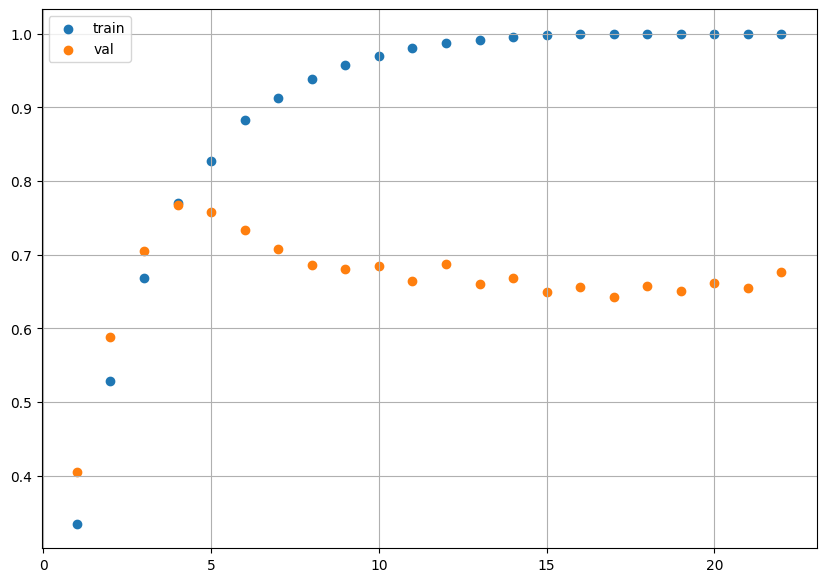

In [21]:
fig,ax = plt.subplots(figsize = (10,7))
plt.scatter(range(1,23),acc_tr, label = 'train')
plt.scatter(range(1,23),acc_val, label = 'val')
plt.grid();
plt.legend();

In [22]:
# I would select a depth of 4, as the difference in accuracy between training and validation is so small, while validation
# accuracy is at its highest

In [23]:
# Now, doing the same for decision tree with poisson criterion
tr = DecisionTreeRegressor(criterion = 'poisson',random_state = 0)
tr.fit(x_tr,y_tr)
tr.get_depth()

22

In [24]:
#Now, optimizing the max_depth hyperparameter for poisson criterion:
acc_tr_p =[]
acc_val_p = []
for i in range(1,23):
    tr = DecisionTreeRegressor(max_depth = i,criterion = 'poisson',random_state = 0)
    tr.fit(x_tr,y_tr)
    acc_tr_p.append(tr.score(x_tr,y_tr))
    acc_val_p.append(tr.score(x_va,y_va))

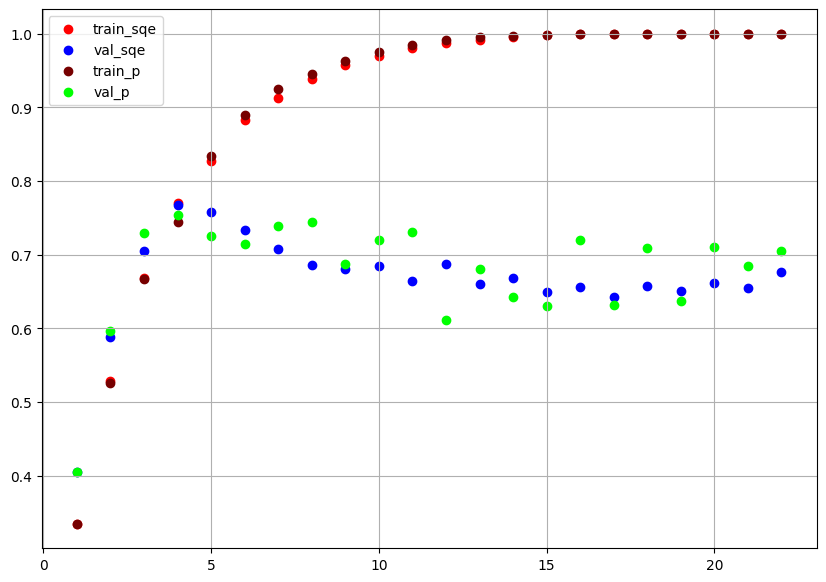

In [25]:
# Comparing models using plot
fig,ax = plt.subplots(figsize = (10,7))
plt.scatter(range(1,23),acc_tr, color = '#FF0000',label = 'train_sqe')
plt.scatter(range(1,23),acc_val, color = '#0000FF',label = 'val_sqe')
plt.scatter(range(1,23),acc_tr_p, color = '#770000',label = 'train_p')
plt.scatter(range(1,23),acc_val_p, color = '#00FF00',label = 'val_p')
plt.grid();
plt.legend();

In [26]:
# At max depth = 4 for squared_error is superior. We have the smallest difference between training and validation data points,
# and the validation score is at its highest at this depth.
#Now, comparing this to linear regression model:
tr = DecisionTreeRegressor(max_depth = 4,random_state = 0)
tr.fit(x_tr,y_tr)
print(tr.score(x_va,y_va))

0.7676768939106761


In [27]:
#Regression model:
print(lr.score(x_va,y_va))

0.7103345183725724


In [28]:
# We can see that based on accuracy for the validation set, 
# the decision tree using squared_error comes out on top.
#Now, we see how well it performs on test data

In [29]:
tr = DecisionTreeRegressor(max_depth = 4,random_state = 0)
tr.fit(x_tr,y_tr)
print(tr.score(x_te,y_te))

0.6785189549507262
